In [39]:
# Import required modules
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Exploratory Data Analysis 

In [2]:
# Return train label counts
train_path="/kaggle/input/breast-cancer/breast-cancer-detection/train"
train_labels=os.listdir(train_path)
for labels in train_labels:
    print('No of images in  train: ', labels ,' '  ,len(os.listdir(os.path.join(train_path,labels))))

No of images in  train:  0   2017
No of images in  train:  1   1030


In [3]:
# Return test label counts
test_path='/kaggle/input/breast-cancer/breast-cancer-detection/test'
test_labels=os.listdir(test_path)
for labels in test_labels:
    print('No of images in test: ', labels ,' '  ,len(os.listdir(os.path.join(test_path,labels))))

No of images in test:  0   208
No of images in test:  1   128


## Data Visualization

In [5]:
# Define function to visialize images
def visualize_images(train_path, train_labels, num_images=5):
   
    plt.figure(figsize=(15, 10))
    for label_idx, label in enumerate(train_labels):
        image_files = os.listdir(os.path.join(train_path, label))
        random_images = random.sample(image_files, min(num_images, len(image_files)))
        
        for i, img_name in enumerate(random_images):
            img_path = os.path.join(train_path, label, img_name)
            img = Image.open(img_path)  
            
            plt.subplot(len(train_labels), num_images, label_idx * num_images + i + 1)
            plt.imshow(img)
            plt.axis('off')  
            plt.title(label)  
            
    plt.tight_layout()
    plt.show()

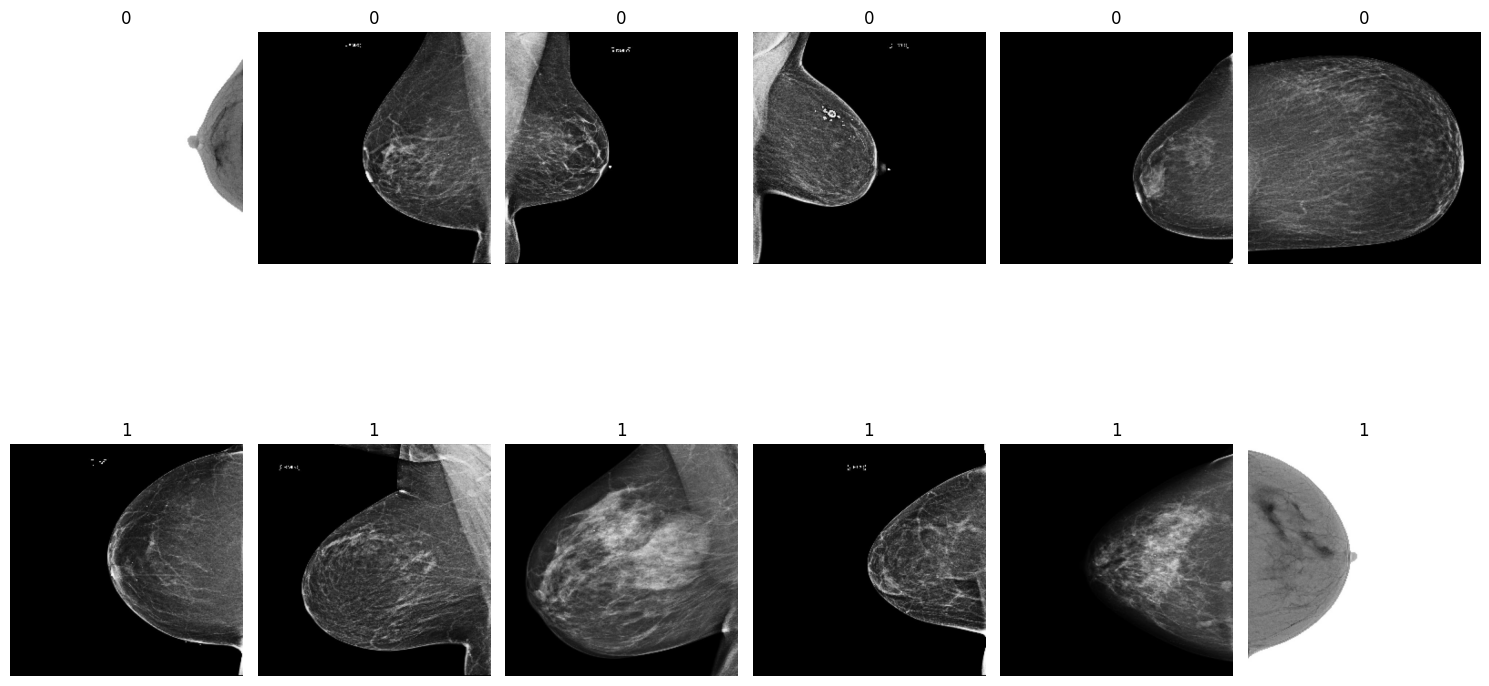

In [6]:
# Visialize some images
visualize_images(train_path, train_labels, num_images=6)

In [4]:
# Define function to create dataframe
def create_image_dataframe(base_path, labels):
    data = []
    for label in labels:
        folder_path = os.path.join(base_path, label)
        image_files = os.listdir(folder_path)
        
        for image in image_files:
            image_path = os.path.join(folder_path, image)
            data.append({'image_path': image_path, 'label': label})
    
    return pd.DataFrame(data)

In [8]:
# Create dataframes.
train_df = create_image_dataframe(train_path, train_labels)
test_df = create_image_dataframe(test_path, test_labels)

train_df.shape, test_df.shape

((3047, 2), (336, 2))

In [9]:
# Concat dataframes
train_df['dataset'] = 'Train'
test_df['dataset'] = 'Test'
combined_df = pd.concat([train_df, test_df], ignore_index=True)

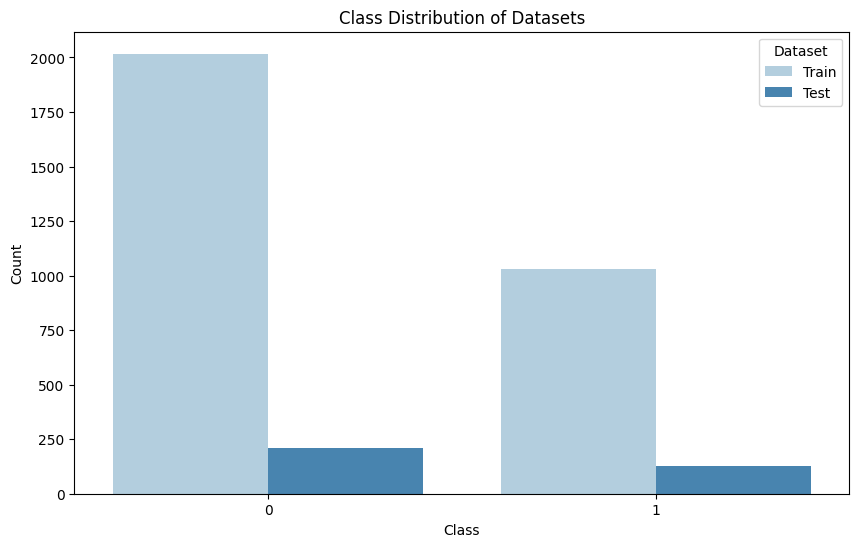

In [10]:
# Return histogram of class images
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='label', hue='dataset', palette='Blues')
plt.title("Class Distribution of Datasets")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend(title="Dataset")
plt.show()

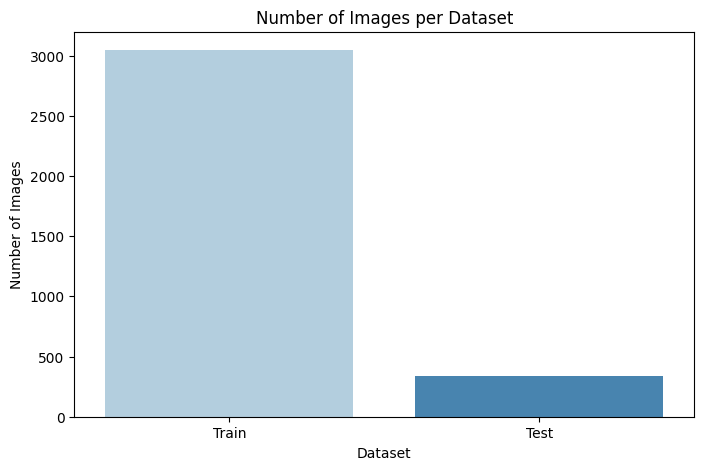

In [11]:
# Return histogram of combined images
dataset_counts = combined_df['dataset'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=dataset_counts.index, y=dataset_counts.values, palette="Blues")
plt.title("Number of Images per Dataset")
plt.xlabel("Dataset")
plt.ylabel("Number of Images")
plt.show()

In [12]:
# Define function to return image size
def get_image_size(path):
    with Image.open(path) as img:
        return img.size

In [13]:
# Get image width and height
combined_df['image_size'] = combined_df['image_path'].apply(get_image_size)
combined_df['width'], combined_df['height'] = zip(*combined_df['image_size'])

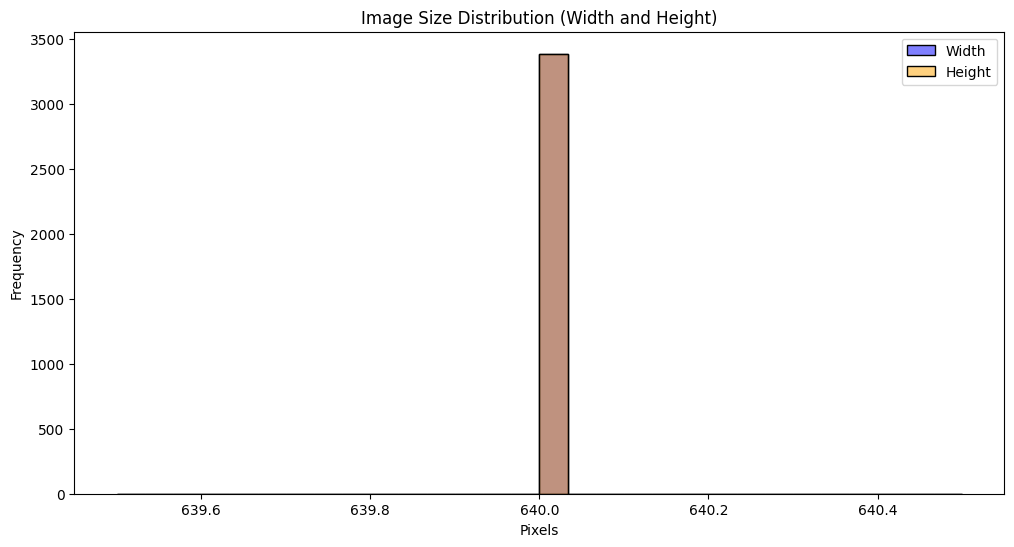

In [14]:
# Plot width and height distribution
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['width'], bins=30, color='blue', label='Width', kde=True)
sns.histplot(combined_df['height'], bins=30, color='orange', label='Height', kde=True)
plt.title("Image Size Distribution (Width and Height)")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Model Creation

## Define functions for reproducibility

In [42]:
# Define function to create dataframes
def create_dataframe(base_path):

    # Define label.
    labels=os.listdir(base_path)

    # Gather data
    data = []
    for label in labels:
        folder_path = os.path.join(base_path, label)
        image_files = os.listdir(folder_path)
        
        for image in image_files:
            image_path = os.path.join(folder_path, image)
            data.append({'image_path': image_path, 'label': label})

    return pd.DataFrame(data)
    


# Define function to create data
def create_data(BATCH_SIZE):
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='image_path',  
        y_col='label',       
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'  
    )
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='image_path',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, test_generator



# Define function to load and fit model
def load_fit(BASE_MODEL, DROP_RATE):
    
    # Load the model pretrained on ImageNet without the top layers
    base_model = BASE_MODEL
    base_model.trainable = True
    
    # Build custom model on top of base model.
    model = base_model.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dense(1024, activation='relu')(model)
    model = tf.keras.layers.Dropout(rate=DROP_RATE)(model)
    model = tf.keras.layers.Dense(2, activation='softmax')(model)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=model)
    
    # Compile model
    model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Fit model
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=EP0CHS,
    )

    # Get training and validation accuracy and loss
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    return accuracy, val_accuracy, loss, val_loss, model



# Define function to return results
def return_results(THE_MODEL):
    print(f'The Results for {THE_MODEL}')
    print(f'Mean Train Accuracy: {round(np.mean(accuracy), 4)}')
    print(f'Mean Test Accuracy: {round(np.mean(val_accuracy), 4)}')
    print(f'Mean Train Loss: {round(np.mean(loss), 4)}')
    print(f'Mean Test Loss: {round(np.mean(val_loss), 4)}')



# Define function to plot results
def plot_results(THE_MODEL):
    
    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'Accuracy Curve for {THE_MODEL}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training and validation loss.
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss Curve for {THE_MODEL}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    
    return plt.show()


# InceptionV3

In [3]:
# Define seed
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the model
THE_MODEL = 'InceptionV3'

# Define constants
IMG_SIZE = (299, 299)
INPUT_SHAPE = (299, 299, 3)

# Define inputs
BATCH_SIZE = 64
DROP_RATE = 0.4
EP0CHS = 10

# Define optimizer
LEARNING_RATE = 0.0001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define base model
BASE_MODEL = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)
  
# Define paths
train_path="/kaggle/input/breast-cancer/breast-cancer-detection/train"
test_path="/kaggle/input/breast-cancer/breast-cancer-detection/test"

# Create dataframes
train_df = create_dataframe(train_path)
test_df = create_dataframe(test_path)

# Get generators
train_generator, test_generator = create_data(BATCH_SIZE)

# Get results
accuracy, val_accuracy, loss, val_loss, model = load_fit(BASE_MODEL, DROP_RATE)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 3047 validated image filenames belonging to 2 classes.
Found 336 validated image filenames belonging to 2 classes.
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.6290 - loss: 0.6909 - val_accuracy: 0.6190 - val_loss: 1.1220
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6500 - loss: 0.6322 - val_accuracy: 0.6190 - val_loss: 0.8040
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6575 - loss: 0.6140 - val_accuracy: 0.6369 - val_loss: 0.6653
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7059 - loss: 0.5654 - val_accuracy: 0.6756 - val_loss: 0.6286
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6891 - loss: 0.5810 - val_accuracy: 0.6696 - val_loss: 0.6932
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6977 - loss: 0.5681 - val_accuracy: 0.6458 - val_loss: 0.6854
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7337 - 

In [4]:
# Return results
return_results(THE_MODEL)

The Results for InceptionV3
Mean Train Accuracy: 0.704
Mean Test Accuracy: 0.6503
Mean Train Loss: 0.5663
Mean Test Loss: 0.7455


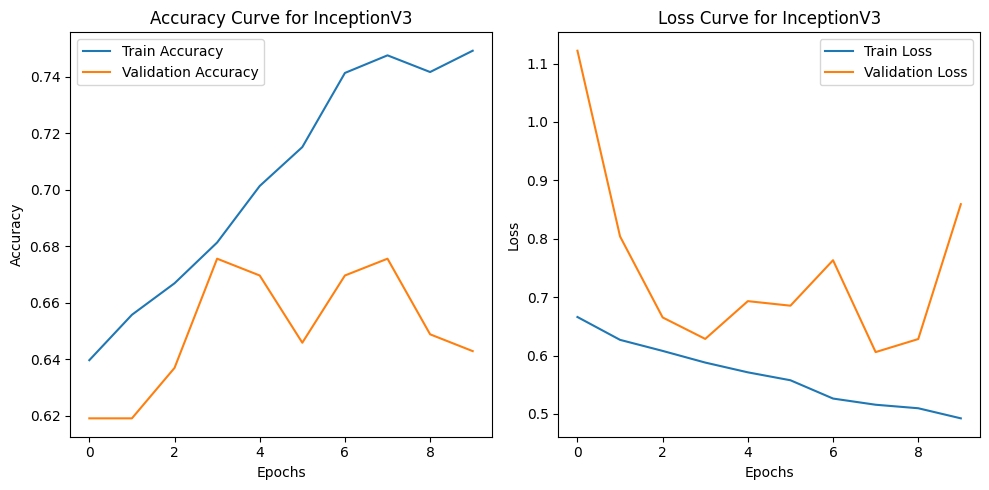

In [5]:
# Plot results
plot_results(THE_MODEL)

## ResNet101V2

In [6]:
# Define seed
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the model
THE_MODEL = 'ResNet101V2'

# Define constants
IMG_SIZE = (299, 299)
INPUT_SHAPE = (299, 299, 3)

# Define inputs
BATCH_SIZE = 64
DROP_RATE = 0.4
EP0CHS = 10

# Define optimizer
LEARNING_RATE = 0.0001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define base model
BASE_MODEL = tf.keras.applications.ResNet101V2(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)
  
# Define paths
train_path="/kaggle/input/breast-cancer/breast-cancer-detection/train"
test_path="/kaggle/input/breast-cancer/breast-cancer-detection/test"

# Create dataframes
train_df = create_dataframe(train_path)
test_df = create_dataframe(test_path)

# Get generators
train_generator, test_generator = create_data(BATCH_SIZE)

# Get results.
accuracy, val_accuracy, loss, val_loss, model = load_fit(BASE_MODEL, DROP_RATE)

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 3047 validated image filenames belonging to 2 classes.
Found 336 validated image filenames belonging to 2 classes.
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 323s 4s/step - accuracy: 0.6098 - loss: 0.7042 - val_accuracy: 0.6161 - val_loss: 0.7758
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6505 - loss: 0.6341 - val_accuracy: 0.6131 - val_loss: 0.7042
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6807 - loss: 0.6008 - val_accuracy: 0.6220 - val_loss: 0.8322
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6991 - loss: 0.5882 - val_accuracy: 0.6399 - val_loss: 0.6866
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.7041 - loss: 0.5765 - val_accuracy: 0.6607 - val_loss: 0.6598
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.7263 - loss: 0.5588 - val_accuracy: 0.6637 - val_loss: 0.6883
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0

In [7]:
# Return results
return_results(THE_MODEL)

The Results for ResNet101V2
Mean Train Accuracy: 0.703
Mean Test Accuracy: 0.6509
Mean Train Loss: 0.5776
Mean Test Loss: 0.6993


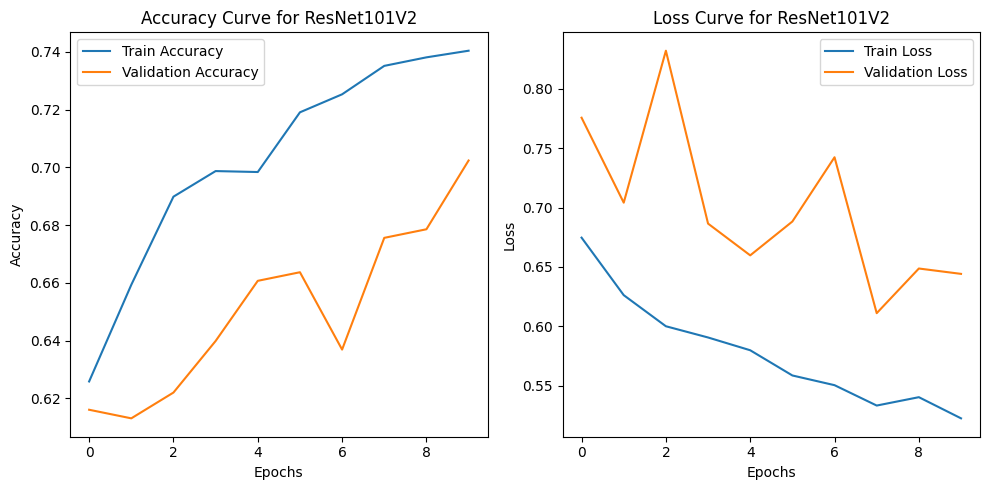

In [8]:
# Plot results
plot_results(THE_MODEL)

## Xception

In [3]:
# Define seed
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the model
THE_MODEL = 'Xception'

# Define constants
IMG_SIZE = (299, 299)
INPUT_SHAPE = (299, 299, 3)

# Define inputs
BATCH_SIZE = 64
DROP_RATE = 0.4
EP0CHS = 10

# Define optimizer.
LEARNING_RATE = 0.0001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define base model
BASE_MODEL = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)
  
# Define paths
train_path="/kaggle/input/breast-cancer/breast-cancer-detection/train"
test_path="/kaggle/input/breast-cancer/breast-cancer-detection/test"

# Create dataframes
train_df = create_dataframe(train_path)
test_df = create_dataframe(test_path)

# Get generators
train_generator, test_generator = create_data(BATCH_SIZE)

# Get results
accuracy, val_accuracy, loss, val_loss, model = load_fit(BASE_MODEL, DROP_RATE)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 3047 validated image filenames belonging to 2 classes.
Found 336 validated image filenames belonging to 2 classes.
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 311s 4s/step - accuracy: 0.6399 - loss: 0.6553 - val_accuracy: 0.6190 - val_loss: 0.7358
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.6618 - loss: 0.6315 - val_accuracy: 0.6190 - val_loss: 0.8124
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.6779 - loss: 0.6041 - val_accuracy: 0.6339 - val_loss: 0.7354
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.6796 - loss: 0.5750 - val_accuracy: 0.6250 - val_loss: 0.7465
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.7232 - loss: 0.5524 - val_accuracy: 0.6429 - val_loss: 0.6869
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.7317 - loss: 0.5198 - val_accuracy: 0.6310 - val_loss: 0.9873
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7

In [4]:
# Return results
return_results(THE_MODEL)

The Results for Xception
Mean Train Accuracy: 0.7251
Mean Test Accuracy: 0.6473
Mean Train Loss: 0.5335
Mean Test Loss: 0.7709


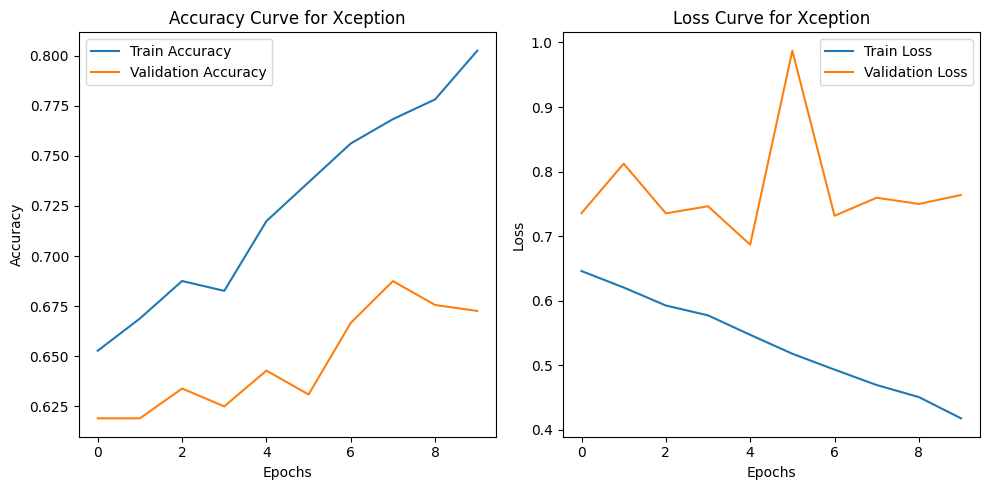

In [5]:
# Plot results
plot_results(THE_MODEL)

## InceptionV3 with BATCH_SIZE = 32

In [43]:
# Define seed
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the model
THE_MODEL = 'InceptionV3'

# Define constants
IMG_SIZE = (299, 299)
INPUT_SHAPE = (299, 299, 3)

# Define inputs
BATCH_SIZE = 32
DROP_RATE = 0.4
EP0CHS = 10

# Define optimizer
LEARNING_RATE = 0.0001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define base model
BASE_MODEL = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)
  
# Define paths
train_path="/kaggle/input/breast-cancer/breast-cancer-detection/train"
test_path="/kaggle/input/breast-cancer/breast-cancer-detection/test"

# Create dataframes
train_df = create_dataframe(train_path)
test_df = create_dataframe(test_path)

# Get generators
train_generator, test_generator = create_data(BATCH_SIZE)

# Get results
accuracy, val_accuracy, loss, val_loss, model = load_fit(BASE_MODEL, DROP_RATE)

Found 3047 validated image filenames belonging to 2 classes.
Found 336 validated image filenames belonging to 2 classes.
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.6281 - loss: 0.6836 - val_accuracy: 0.6190 - val_loss: 0.7037
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 637ms/step - accuracy: 0.6730 - loss: 0.6170 - val_accuracy: 0.6220 - val_loss: 0.6624
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 66s 637ms/step - accuracy: 0.6744 - loss: 0.5999 - val_accuracy: 0.6310 - val_loss: 0.6458
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 644ms/step - accuracy: 0.7061 - loss: 0.5754 - val_accuracy: 0.6637 - val_loss: 0.6023
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 646ms/step - accuracy: 0.6847 - loss: 0.5779 - val_accuracy: 0.6220 - val_loss: 0.6324
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 651ms/step - accuracy: 0.7198 - loss: 0.5508 - val_accuracy: 0.6577 - val_loss: 0.6303
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 653ms/step - accuracy: 0.7271 - loss: 0.5340 - val_accuracy: 0.67

In [44]:
# Return results
return_results(THE_MODEL)

The Results for InceptionV3
Mean Train Accuracy: 0.706
Mean Test Accuracy: 0.6542
Mean Train Loss: 0.5677
Mean Test Loss: 0.6335


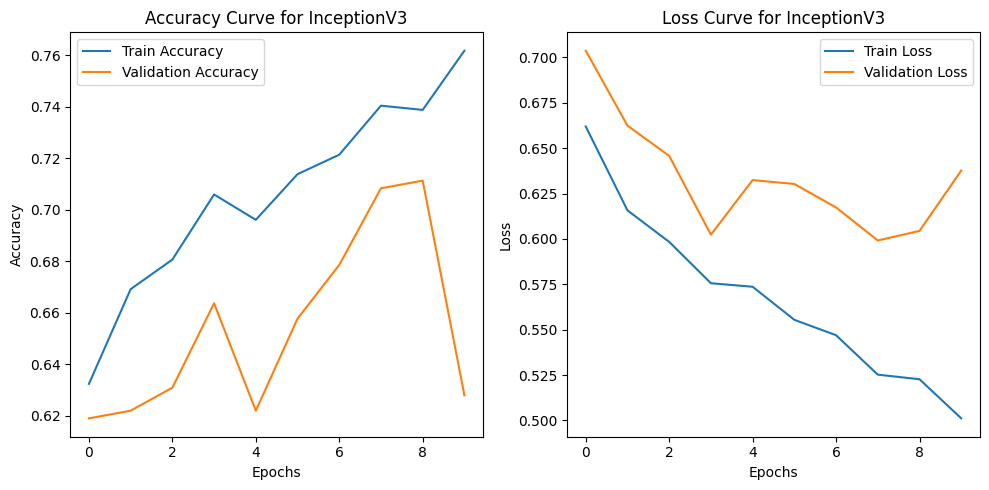

In [45]:
# Plot results
plot_results(THE_MODEL)

## InceptionV3 with DROP_RATE = 0.5

In [9]:
# Define seed
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the model
THE_MODEL = 'InceptionV3'

# Define constants.
IMG_SIZE = (299, 299)
INPUT_SHAPE = (299, 299, 3)

# Define inputs
BATCH_SIZE = 64
DROP_RATE = 0.5
EP0CHS = 10

# Define optimizer
LEARNING_RATE = 0.0001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define base model
BASE_MODEL = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)
  
# Define paths
train_path="/kaggle/input/breast-cancer/breast-cancer-detection/train"
test_path="/kaggle/input/breast-cancer/breast-cancer-detection/test"

# Create dataframes
train_df = create_dataframe(train_path)
test_df = create_dataframe(test_path)

# Get generators
train_generator, test_generator = create_data(BATCH_SIZE)

# Get results
accuracy, val_accuracy, loss, val_loss, model = load_fit(BASE_MODEL, DROP_RATE)

Found 3047 validated image filenames belonging to 2 classes.
Found 336 validated image filenames belonging to 2 classes.
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.6106 - loss: 0.6917 - val_accuracy: 0.6220 - val_loss: 0.7341
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6490 - loss: 0.6351 - val_accuracy: 0.6339 - val_loss: 0.6601
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6702 - loss: 0.6043 - val_accuracy: 0.6369 - val_loss: 0.6571
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6917 - loss: 0.5812 - val_accuracy: 0.6429 - val_loss: 0.6129
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7131 - loss: 0.5608 - val_accuracy: 0.6488 - val_loss: 0.6540
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7371 - loss: 0.5236 - val_accuracy: 0.6786 - val_loss: 0.6031
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7406 - loss: 0.5109 - val_accuracy: 0.6667 - val_loss: 0.6

In [10]:
# Return results
return_results(THE_MODEL)

The Results for InceptionV3
Mean Train Accuracy: 0.7089
Mean Test Accuracy: 0.6622
Mean Train Loss: 0.5609
Mean Test Loss: 0.6304


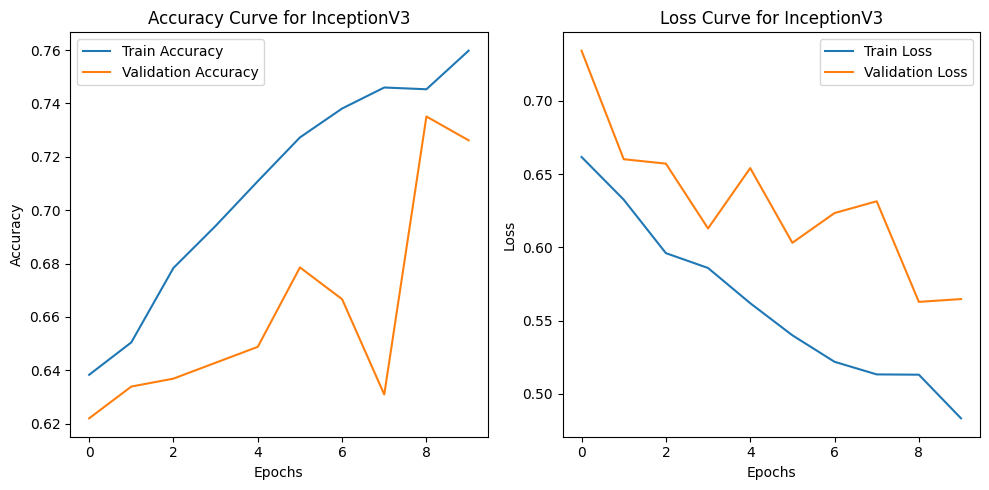

In [11]:
# Plot results
plot_results(THE_MODEL)

## InceptionV3 with LEARNING_RATE = 0.00001

In [13]:
# Define seed
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the model
THE_MODEL = 'InceptionV3'

# Define constants.
IMG_SIZE = (299, 299)
INPUT_SHAPE = (299, 299, 3)

# Define inputs
BATCH_SIZE = 64
DROP_RATE = 0.5
EP0CHS = 10

# Define optimizer
LEARNING_RATE = 0.0001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define base model
BASE_MODEL = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)
  
# Define paths
train_path="/kaggle/input/breast-cancer/breast-cancer-detection/train"
test_path="/kaggle/input/breast-cancer/breast-cancer-detection/test"

# Create dataframes
train_df = create_dataframe(train_path)
test_df = create_dataframe(test_path)

# Get generators
train_generator, test_generator = create_data(BATCH_SIZE)

# Get results
accuracy, val_accuracy, loss, val_loss, model = load_fit(BASE_MODEL, DROP_RATE)

Found 3047 validated image filenames belonging to 2 classes.
Found 336 validated image filenames belonging to 2 classes.
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.6076 - loss: 0.7151 - val_accuracy: 0.6190 - val_loss: 0.9319
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6530 - loss: 0.6347 - val_accuracy: 0.6220 - val_loss: 0.6952
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6719 - loss: 0.6033 - val_accuracy: 0.6220 - val_loss: 0.8815
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.6726 - loss: 0.6089 - val_accuracy: 0.6369 - val_loss: 0.7263
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.6951 - loss: 0.5826 - val_accuracy: 0.6488 - val_loss: 0.6791
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7045 - loss: 0.5605 - val_accuracy: 0.6696 - val_loss: 0.6193
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7105 - loss: 0.5423 - val_accuracy: 0.6071 - val_loss: 0.6

In [14]:
# Return results
return_results(THE_MODEL)

The Results for InceptionV3
Mean Train Accuracy: 0.701
Mean Test Accuracy: 0.6506
Mean Train Loss: 0.5706
Mean Test Loss: 0.6987


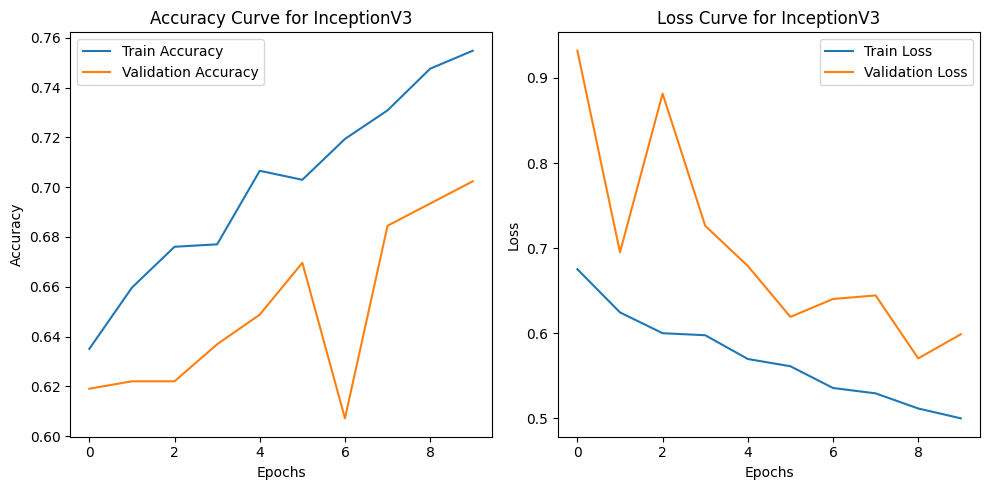

In [15]:
# Plot results
plot_results(THE_MODEL)

## InceptionV3 with BATCH_SIZE = 32, DROP_RATE = 0.5, LEARNING_RATE = 0.00001, EP0CHS = 30

In [27]:
# Define seed
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the model
THE_MODEL = 'InceptionV3'

# Define constants
IMG_SIZE = (299, 299)
INPUT_SHAPE = (299, 299, 3)

# Define inputs
BATCH_SIZE = 32
DROP_RATE = 0.5
EP0CHS = 30

# Define optimizer
LEARNING_RATE = 0.00001
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Define base model
BASE_MODEL = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)
  
# Define paths
train_path="/kaggle/input/breast-cancer/breast-cancer-detection/train"
test_path="/kaggle/input/breast-cancer/breast-cancer-detection/test"

# Create dataframes
train_df = create_dataframe(train_path)
test_df = create_dataframe(test_path)

# Get generators
train_generator, test_generator = create_data(BATCH_SIZE)

# Get results
accuracy, val_accuracy, loss, val_loss, model = load_fit(BASE_MODEL, DROP_RATE)

Found 3047 validated image filenames belonging to 2 classes.
Found 336 validated image filenames belonging to 2 classes.
Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.5773 - loss: 0.7183 - val_accuracy: 0.6190 - val_loss: 0.7383
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 653ms/step - accuracy: 0.6252 - loss: 0.6682 - val_accuracy: 0.6190 - val_loss: 0.7176
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 653ms/step - accuracy: 0.6504 - loss: 0.6537 - val_accuracy: 0.6220 - val_loss: 0.6980
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 68s 655ms/step - accuracy: 0.6581 - loss: 0.6224 - val_accuracy: 0.6339 - val_loss: 0.6512
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 71s 681ms/step - accuracy: 0.6701 - loss: 0.6236 - val_accuracy: 0.6429 - val_loss: 0.6410
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 74s 727ms/step - accuracy: 0.6525 - loss: 0.6278 - val_accuracy: 0.6429 - val_loss: 0.6250
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 67s 648ms/step - accuracy: 0.6922 - loss: 0.6018 - val_accuracy: 0.65

In [28]:
# Return results
return_results(THE_MODEL)

The Results for InceptionV3
Mean Train Accuracy: 0.715
Mean Test Accuracy: 0.6725
Mean Train Loss: 0.5475
Mean Test Loss: 0.6174


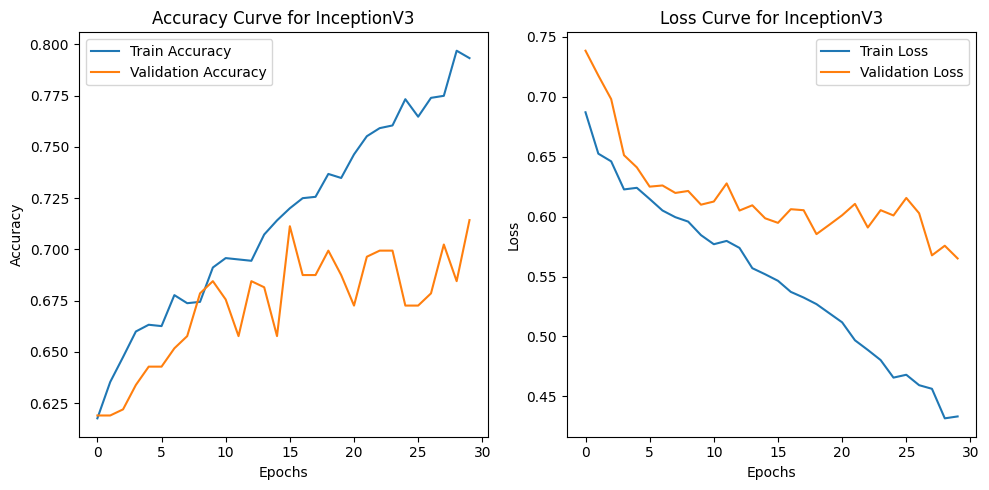

In [29]:
# Plot results
plot_results(THE_MODEL)

In [30]:
# Save model
tf.keras.Model.save(model, 'breast_cancer.keras')

In [31]:
# Check for saved model
!dir

breast_cancer.keras


In [33]:
# Reload model
reloaded_model = tf.keras.models.load_model('breast_cancer.keras')

In [34]:
# Return summary of reloaded_model
reloaded_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_376 (Conv2D)       │ (None, 149, 149, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_376   │ (None, 149, 149, 32)   │             96 │ conv2d_376[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_376            │ (None, 149, 149, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_377 (Conv2D)       │ (None, 147, 147, 32)   │          9,216 │ activation_376[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_377   │ (None, 147, 147, 32)   │             96 │ conv2d_377[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_377            │ (None, 147, 147, 32)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_378 (Conv2D)       │ (None, 147, 147, 64)   │         18,432 │ activation_377[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_378   │ (None, 147, 147, 64)   │            192 │ conv2d_378[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_378            │ (None, 147, 147, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 73, 73, 64)     │              0 │ activation_378[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_379 (Conv2D)       │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_379   │ (None, 73, 73, 80)     │            240 │ conv2d_379[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_379            │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_380 (Conv2D)  

 Total params: 71,640,168 (273.29 MB)

 Trainable params: 23,868,578 (91.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

 Optimizer params: 47,737,158 (182.10 MB)